# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

from utils import load_yaml

sns.set_theme()

# Utility Functions

## Data Loading Functions

In [223]:
from tqdm import tqdm


def load_dataframes(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load and return all of them.
    """
    if verbose:
        print(f"Loading from: {eval_folder.name}")
    all_frames = [pd.read_pickle(f) for f in eval_folder.glob("*.pkl")]
    if verbose:
        print(f"Loaded {len(all_frames)} dataframes for {eval_folder.name}.")
    return all_frames


def load_eval_data(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load all results into a single dataframe.
    """
    all_frames = load_dataframes(eval_folder)  # Don't need the verbose flag here b/c the same info is printed below.
    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        name = eval_folder.parent.name + "/" + eval_folder.name
        print(f"{name}: Loaded {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def load_eval_data_with_model_info(model_name, eval_folder, add_pretrain_info=True, verbose=False):
    """
    Load dataframes in the given folder, and replace the "model" column with the given `model_name`.
    """
    all_data = load_eval_data(eval_folder, verbose)

    # Replace model path with model shortname.
    # TODO: Need to find a more efficient way to do this.
    if len(all_data) > 0:
        # Here's the original way to do it, and it's way too slow.
        #orig = all_data.index.get_level_values("model")[0]  # Get original name.
        #all_data.rename(index={orig: model_name}, level="model", inplace=True)  # Replace with short name.
        newdex = all_data.index.to_frame(index=False)
        newdex["model"] = model_name  # Replace entire model column w/ short name.
        if add_pretrain_info:
            # Add info from a few select columns so we can use it for filtering/grouping.
            train_cfg = train_configs[eval_folder.parent.stem]
            # We would allow them to be null if missing, except NaNs will mess up our groupbys due to a known bug
            # in Pandas: https://github.com/pandas-dev/pandas/issues/36470
            # Thus, we must supply non-null defaults.
            info_cols = [("model_name", "n/a"), ("train_method", "n/a"), ("lobotomize", False)]
            for k, dflt in info_cols:
                # Unfortunately our default for lobo is context-dependent. :-(
                if k == "lobotomize":
                    dflt = (train_cfg.get("train_method") != "iid")
                newdex[k] = train_cfg.get(k, dflt)
        newdex = pd.MultiIndex.from_frame(newdex, names=newdex.columns)
        all_data.set_index(newdex, inplace=True)

    return all_data


## Summarization Functions

Functions for processing dataframes to find the best performance within certain groupings.

In [333]:
from functools import partial


def combine_train_test_columns(df):
    # Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
    df = df.rename(columns={"train_acc": "train", "test_acc": "test"})
    return df.melt(var_name="split", value_name="accuracy", ignore_index=False)


def get_index_columns(df, include=None, exclude=None):
    if not include:
        include = df.index.names
    if not exclude:
        exclude = []
    return list(filter(lambda x: x in include and x not in exclude, df.index.names))


def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")


def filter_by_model(df, desired_models):
    """
    Filter the given dataframe to only contain the models from the given list.
    """
    models = df.index.get_level_values("model")
    top_model_rows = (models == desired_models[0])
    for m in desired_models[1:]:
        top_model_rows |= (models == m)
    return df.loc[top_model_rows]


def filter_to_match_models(df1, df2):
    """
    Filter `df1` to only contain the models found in `df2`.
    """
    return filter_by_model(df1, df2.index.get_level_values("model").unique())


def select_best_lr(groupby_labels, train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    test_perf = train_group.loc[train_group["split"] == "test"]
    perf_per_lr = test_perf.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = perf_per_lr.iloc[perf_per_lr.squeeze().argmax()].name
    # Grabs all trials corresponding to the best LR.
    best_lr_rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[best_lr_rows].reset_index(level=groupby_labels, drop=True)


def select_best_lr_per_group(df):
    """
    Filters the given dataframe so it contains just the results of the best-performing learning rate at each point in
    time, for each different model / fine-tuning process. Note: this means different learning rates can be selected for
    different points _within the same training run_. Performance is measured as the average test accuracy over all
    trials (mean over the "trial" column).
    """
    # Group the potential data for each data point separately. So each group contains all trials and all learning rates
    # for a single test method (so all index columns except for those).
    groupby_labels = get_index_columns(df, exclude=["lr", "trial"])
    eval_groups = df.groupby(groupby_labels, dropna=False)

    # For each point on the x-axis, select the learning rate with the best average performance over trials.
    # Need to use .apply() here because our function needs all columns at once.
    return eval_groups.apply(partial(select_best_lr, groupby_labels))


def get_final_perf_per_model(df, num_train_examples=None, print_result=False):
    """
    Gets and (optionally) prints the mean final test accuracy of each model in the given dataframe.
    """
    models = df.index.get_level_values("model")
    test_rows = (df["split"] == "test")
    if num_train_examples is not None:
        train_example_rows = df.index.get_level_values("train_examples") == num_train_examples
    else:
        train_example_rows = None
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    if "classes_trained" in df.index.names:
        classes_trained = df.index.get_level_values("classes_trained")
        final_perf_rows = (classes_trained == classes_trained.max())
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        final_perf_rows = (step == step.max())
    else:
        final_perf_rows = None

    if print_result:
        total_classes = df.index.get_level_values("classes").unique()
        if len(total_classes) > 1:
            print(f"WARNING: Aggregating over multiple class values:\n{total_classes}")
            cls_msg = ""
        else:
            cls_msg = f" on {total_classes.item()} classes"
        print(f"Final accuracy{cls_msg}:")

    final_perf_per_model = {}
    for m in models.unique():
        rows = (models == m) & test_rows
        if train_example_rows is not None:
            rows &= train_example_rows
        if final_perf_rows is not None:
            rows &= final_perf_rows
        final_acc = df.loc[rows, "accuracy"]
        stats = pd.DataFrame.from_records([{"model": m, "mean": final_acc.mean(), "std": final_acc.std()}],
                                          index="model")
        final_perf_per_model[m] = stats
        if print_result:
            print(f"{m: >30} | {stats['mean'].item():>5.1%} (std: {stats['std'].item():.1%})")

    return final_perf_per_model


def get_top_model_per_group(df, performance_per_model, group_cols=None):
    """
    Groups by the given columns and returns one model per group, where each model

    Args:
        df: The dataframe containing pre-trained model info.
        performance_per_model: A dict with model names as keys and performance stats as values (higher is better).
        group_cols: A list of columns used to define the groups. Defaults to ["train_method", "lobotomize"] if not
                    supplied.

    Returns:
        A dataframe with one row per group, indexed by group columns and with a single column with the model names.
    """
    if not group_cols:
        group_cols = ["train_method", "lobotomize"]

    def select_best_model(train_group):
        models = train_group.index.get_level_values("model").unique()
        # Sort by mean and return the highest (last) one.
        return sorted([performance_per_model[m] for m in models], key=lambda e: e["mean"].item())[-1]

    # Now select the best model within each group.
    pretrain_groups = df.groupby(group_cols, dropna=False)
    return pretrain_groups.apply(select_best_model)


## Plotting Functions

In [378]:
import warnings


def add_category_column(df, groupcols=None):
    """
    Add a column to the given dataframe which summarizes the category groups in a string. Used to make an improved
    legend in plots. If `groupcols` is not provided, it defaults to ["train_method", "lobotomize"].
    """
    if not groupcols:
        groupcols = ["train_method", "lobotomize"]
    grouppos = [df.index.names.index(c) for c in groupcols]
    name_mapping = {
        "lobotomize": "lobo",
        "train_method": "method",
        "sequential_episodic": "seqep",
    }

    def map_name(name):
        return name_mapping.get(name, name)

    def make_valstring(row):
        msg = f"{map_name(groupcols[0])}={map_name(row.name[grouppos[0]])}"
        for i in range(1, len(groupcols)):
            msg += f", {map_name(groupcols[i])}={map_name(row.name[grouppos[i]])}"
        return msg

    df["category"] = df.apply(make_valstring, axis=1)


# Plot the results from the previous cell.
def plot_traj_per_lr(df, **kwargs):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    if "hue" not in kwargs and df.index.get_level_values("model").nunique() > 1:
        kwargs["hue"] = "model"
    if "style" not in kwargs and df.index.get_level_values("train_examples").nunique() > 1:
        kwargs["style"] = "train_examples"
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    xname = "Step"
    if "x" not in kwargs:
        if "classes_trained" in df.index.names:
            kwargs["x"] = "classes_trained"
            xname = "Classes Trained"
        elif "step" in df.index.names:
            kwargs["x"] = "step"
        else:
            raise RuntimeError("Unable to find a suitable x-axis variable in the dataframe.")

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            y="accuracy",
            row="split",
            kind="line",
            ci="sd",
            height=5,
            aspect=2.5,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.90)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels(xname, "Accuracy")

# Data Loading

## Scan for Trained Models

Given a project folder, we will scan for all the training jobs in that folder. Each training job has produced a number of model checkpoints, and we will find all the ones which have already been evaluated.

This assumes that project folders have the structure: `<project>/<training-job>/train-config.yml`.

In [4]:
# Original Omniglot results.
#PROJECT_ROOT = Path("../experiments/flat-vs-nested")
# Original ImageNet results.
PROJECT_ROOT = Path("../experiments/inet-flat-vs-nested").resolve()

In [5]:
# Create a map from name -> training config.
train_config_files = {}
for f in PROJECT_ROOT.iterdir():
    if f.is_dir():
        cfg_path = f / "train-config.yml"
        if cfg_path.is_file():
            train_config_files[f.stem] = cfg_path

# Let's sort the dict by model name, for convenience.
train_config_files = dict(sorted(train_config_files.items()))

In [6]:
# Load the YAML files.
train_configs = {k: load_yaml(v) for k, v in train_config_files.items()}
print(f"Found {len(train_configs)} training jobs.")

Found 57 training jobs.


## Choose the "Best" Checkpoint

Each model may have a number of evaluated checkpoints. For each training job, we'll choose just one checkpoint to use for evaluation. We'll do so by choosing the checkpoint with the best "zero-shot" or "no-SGD" performance.

Note that there are a bunch of assumptions in the code below about what results we actually have:
1. All models have no-SGD results, otherwise they're ignored.
1. Each checkpoint only has one no-SGD evaluation.
1. Each no-SGD folder only contains one set of trials.
1. Some assumptions on the naming of these folders.
If we ever decide to run more different no-SGD evals then these assumptions need to be revisited.

In [7]:
def best_checkpoint(eval_folders):
    if len(eval_folders) == 1:
        return eval_folders[0]
    perfs = np.array([final_performance(f) for f in eval_folders])
    if np.all(np.isnan(perfs)):
        return None
    return eval_folders[np.nanargmax(perfs)]


def final_performance(eval_folder):
    df = load_eval_data(eval_folder)
    if df.empty:
        return np.nan
    # WARNING: Assumes all datapoints in this folder correspond to a single evaluation (we don't need to filter down
    # to the evaluation we actually want).
    return df["test_acc"].mean()


def get_checkpoint_number(eval_folder):
    # WARNING: This CLOSELY depends on the naming of the eval folders, and I'm not sure it'll always work.
    return int(eval_folder.stem.split("-")[2])


best_checkpoints = {}
for name, f in train_config_files.items():
    pdir = f.parent
    # First check for folders just ending with "no-sgd".
    no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
    if not no_sgd_evals:
        # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
        if not no_sgd_evals:
            print(f"WARNING: Could not find no-SGD results for {name}.")
            continue
            # If you want to debug this condition, uncomment the following line:
            # print(f"Files: {[f.name for f in pdir.iterdir()]}")

    # Now we have a list of evals; assuming one per checkpoint.
    best = best_checkpoint(no_sgd_evals)
    if best is not None:
        best_checkpoints[name] = get_checkpoint_number(best)
    else:
        print(f"WARNING: All no-SGD results for {name} are empty.")

In [8]:
# Create a map of name -> list of eval folders for the best checkpoint.
# WARNING: Closely depends on the naming of the eval folders, and may not stand the test of time.
all_eval_folders = {name: list((PROJECT_ROOT / name).glob(f"eval-*-{ckpt}-*"))
                    for name, ckpt in best_checkpoints.items()}
# Sanity check.
missing_results = []
invalid_results = []
for name, l in all_eval_folders.items():
    if len(l) <= 1:
        # The only result is the no-sgd result, or even that was not found for some reason.
        missing_results.append(name)
    for f in l:
        if not f.is_dir():
            # Not a valid results dir.
            invalid_results.append(f)

if missing_results:
    for name in missing_results:
        print(f"WARNING: Unable to find any results for {name}, checkpoint #{best_checkpoints[name]}.")
if invalid_results:
    print(f"ERROR: The following should be valid directories but are not:\n{[f.name for f in invalid_results]}")

## Load Evaluation Data

Now, for each model, we have all the evals performed on the best model checkpoint. We'd like to load all these evals into a single dataframe for further processing.

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename. We'll name them using the training job name and the model checkpoint.

In [185]:
%%time

import re
from collections import defaultdict

# Organize dataframes by evaluation type.
all_frames = defaultdict(list)
for name, eval_folders in tqdm(all_eval_folders.items()):
    #print(f"Loading {len(eval_folders)} evaluations for {name}...")
    for folder in eval_folders:
        eval_type = re.match(r".*?-[0-9]+-(.*)$", folder.name).group(1)
        eval_data = load_eval_data_with_model_info(f"{name}-{best_checkpoints[name]}", folder)
        all_frames[eval_type].append(eval_data)

print("Evaluation Results:")
for eval_type in all_frames:
    before_concat = all_frames[eval_type]
    all_frames[eval_type] = pd.concat(before_concat)
    print(f"  {eval_type}: {len(before_concat)} models -> {all_frames[eval_type].shape} dataframe")

100%|██████████| 44/44 [01:44<00:00,  2.38s/it]


Evaluation Results:
  unfrozen: 39 models -> (5204000, 2) dataframe
  olft: 39 models -> (5420000, 2) dataframe
  iid-olft: 39 models -> (61710, 4) dataframe
  no-sgd: 44 models -> (390, 4) dataframe
  iid-lstsq-unfrozen: 39 models -> (62950, 4) dataframe
  iid-unfrozen: 39 models -> (65470, 4) dataframe
  lstsq-unfrozen: 39 models -> (4612000, 2) dataframe
CPU times: user 1min 30s, sys: 15.9 s, total: 1min 46s
Wall time: 2min 8s


In [91]:
# Clear up what memory we can, in case we are loading some large frames...
# In my experiment with 144M rows, this took memory from 7.2 GB --> 6.2 GB; not that much, unfortunately.
import gc
_ = gc.collect()

## Dataframe View

In [260]:
all_frames["olft"]

train_acc  \
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr    trial epoch classes_trained class_id model_name train_method lobotomize              
absurd-wave-14899-2000    miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.010 0     0     1               0        n/a        iid          False             1.0   
                                                                                                                                                                     1        n/a        iid          False             0.0   
                                                                                                                                                                     2        n/a        iid          False             0.0   
                                                                                                                                                                     3        n/a        iid          False             0.0   
                                                                                                                                                                     4        n/a        iid          False             0.0   
...                                                                                                                                                                                                                     ...   
youthful-wood-32388-10000 miniimagenet 20             200           sequential  kaiming       classifier.linear classifier 20      0.055 9     19    20              15       n/a        meta         False             0.0   
                                                                                                                                                                     16       n/a        meta         False             0.0   
                                                                                                                                                                     17       n/a        meta         False             0.0   
                                                                                                                                                                     18       n/a        meta         False             0.0   
                                                                                                                                                                     19       n/a        meta         False             1.0   

                                                                                                                                                                                                                  test_acc  
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr    trial epoch classes_trained class_id model_name train_method lobotomize            
absurd-wave-14899-2000    miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.010 0     0     1               0        n/a        iid          False            1.0  
                                                                                                                                                                     1        n/a        iid          False            0.0  
                                                                                                                                                                     2        n/a        iid          False            0.0  
                                                                                                                                                                     3        n/a        iid          False  

# Determine the "Best" Versions of Each Pre-Train Type

For each of the different pre-train settings we're interested in, we've trained that setting with a number of different hyperparameters. Within each setting, we want to select the best single set of hyperparams. We'll do this by using the No-SGD performance as a proxy for overall "goodness".

In [187]:
# Using No-SGD performance as a proxy for overall performance.
perf_proxy = all_frames["no-sgd"]

# Make sure we are using the full downstream dataset to estimate performance.
# TODO: Change this to 500. For now, we only have data for 30 examples per class. :-(
rows = perf_proxy.index.get_level_values("train_examples") == 30
desired_rows = perf_proxy.loc[rows]

# Group the potential data for each data point separately. So each group contains all trials and all learning rates for
# a single test method (so all index columns except for those).
perf_proxy_pretrain_groups = desired_rows.groupby(["train_method", "lobotomize"], dropna=False)

def select_best_model(train_group):
    """
    Returns the best model among this group, according to mean test accuracy.
    """
    model_perf = train_group.groupby("model").mean()
    # Tells us which LR is the best.
    return model_perf.iloc[model_perf.loc[:, "test_acc"].argmax()].name

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_model_per_setting = perf_proxy_pretrain_groups.apply(select_best_model)
best_model_per_setting

train_method         lobotomize
iid                  False            absurd-wave-14899-2000
meta                 False         youthful-wood-32388-10000
                     True          curious-brook-15280-10000
sequential_episodic  False            pious-dream-32403-5000
                     True           silvery-salad-15281-9000
dtype: object

# Sequential Fine-Tuning Evaluation

In the sequential evaluation method, we record per-class performance separately for each class at each step of training. For most plots, we only want to evaluate on classes seen so far, so we insert NaN values in places where the class had not yet been trained on. In addition, we only want to see overall performance, not per-class performance, so we summarize this ahead of time.

These steps aren't needed for other training methods, since we don't record per-class performance in those cases.

In [192]:
def summarize_per_class_performance(classes_seen_perf, inplace=False):
    if not inplace:
        classes_seen_perf = classes_seen_perf.copy()

    # Nix all rows where classes_trained <= class_id.
    unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <=
                   classes_seen_perf.index.get_level_values("class_id"))
    classes_seen_perf[unseen_rows] = np.nan

    # Average over all classes to get overall performance numbers, by grouping by columns other than class.
    groupby_labels = get_index_columns(classes_seen_perf, exclude=["class_id"])
    over_all_classes = classes_seen_perf.groupby(groupby_labels, dropna=False).mean()

    if not inplace:
        # Optional deletion of intermediate data to save more memory.
        del classes_seen_perf
        _ = gc.collect()

    return over_all_classes

## One-Layer Fine-Tuning

Summarize the One-Layer Fine-Tuning (OLFT) data, and view the dataframe to check the structure.

In [336]:
%%time

olft_over_all_classes = summarize_per_class_performance(all_frames["olft"])
olft_over_all_classes

CPU times: user 5.27 s, sys: 2.65 s, total: 7.92 s
Wall time: 23.5 s


train_acc  \
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr       trial epoch classes_trained model_name train_method lobotomize              
absurd-wave-14899-2000    miniimagenet 10             200           sequential  kaiming       classifier.linear classifier 20      0.000005 0     0     1               n/a        iid          False        0.000000   
                                                                                                                                                  1     2               n/a        iid          False        0.000000   
                                                                                                                                                  2     3               n/a        iid          False        0.000000   
                                                                                                                                                  3     4               n/a        iid          False        0.000000   
                                                                                                                                                  4     5               n/a        iid          False        0.000000   
...                                                                                                                                                                                                               ...   
youthful-wood-32388-10000 miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.100000 9     15    16              n/a        meta         False        0.062500   
                                                                                                                                                  16    17              n/a        meta         False        0.058824   
                                                                                                                                                  17    18              n/a        meta         False        0.055556   
                                                                                                                                                  18    19              n/a        meta         False        0.052632   
                                                                                                                                                  19    20              n/a        meta         False        0.050000   

                                                                                                                                                                                                            test_acc  
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr       trial epoch classes_trained model_name train_method lobotomize            
absurd-wave-14899-2000    miniimagenet 10             200           sequential  kaiming       classifier.linear classifier 20      0.000005 0     0     1               n/a        iid          False       0.000000  
                                                                                                                                                  1     2               n/a        iid          False       0.000000  
                                                                                                                                                  2     3               n/a        iid          False       0.000000  
                                                                                                                                                  3     4               n/a        iid          False       0.000000  
                                                                                            

In [337]:
olft_overall_accuracy = combine_train_test_columns(olft_over_all_classes)

Now, plot a graph with the best learning rate per data point.

In [338]:
# Filter the data to just 30 examples per class.
num_train_examples = 30
rows = olft_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
desired_rows = olft_overall_accuracy.loc[rows]
olft_best_lrs = select_best_lr_per_group(desired_rows)

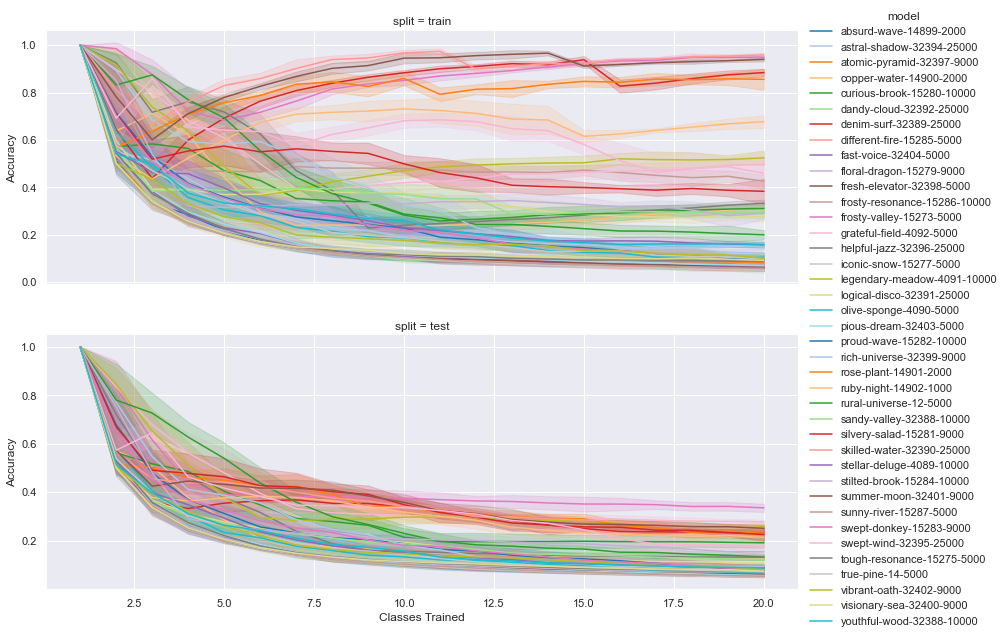

In [339]:
# Plot results
fg = plot_traj_per_lr(olft_best_lrs, palette="tab20")

### Best Models Overall

In [340]:
# Print final accuracy per model, when fine-tuned on this number of examples.
olft_perf_per_model = get_final_perf_per_model(olft_best_lrs, num_train_examples, print_result=True)

Final accuracy on 20 classes:
        absurd-wave-14899-2000 |  5.5% (std: 0.5%)
     astral-shadow-32394-25000 |  7.9% (std: 0.8%)
     atomic-pyramid-32397-9000 |  7.6% (std: 1.7%)
       copper-water-14900-2000 | 12.9% (std: 0.9%)
     curious-brook-15280-10000 | 13.3% (std: 1.3%)
       dandy-cloud-32392-25000 |  5.5% (std: 0.6%)
        denim-surf-32389-25000 | 23.1% (std: 1.3%)
     different-fire-15285-5000 |  5.0% (std: 0.1%)
         fast-voice-32404-5000 |  5.9% (std: 0.5%)
      floral-dragon-15279-9000 |  6.2% (std: 0.4%)
     fresh-elevator-32398-5000 |  6.1% (std: 0.9%)
  frosty-resonance-15286-10000 |  9.7% (std: 1.0%)
      frosty-valley-15273-5000 | 33.5% (std: 1.7%)
      grateful-field-4092-5000 | 27.7% (std: 1.0%)
      helpful-jazz-32396-25000 | 13.2% (std: 1.2%)
        iconic-snow-15277-5000 |  5.0% (std: 0.0%)
   legendary-meadow-4091-10000 | 25.7% (std: 1.5%)
     logical-disco-32391-25000 | 10.7% (std: 0.5%)
        olive-sponge-4090-5000 |  7.0% (std: 0.7%)
 

In [342]:
# Get the top N models according to final test performance.
num_top_models = 5
sorted_models = sorted(olft_perf_per_model, key=lambda k: olft_perf_per_model[k]["mean"].item(), reverse=True)
top_models = sorted_models[:num_top_models]
print(f"Top models: {top_models}")
top_model_df = filter_by_model(olft_best_lrs, top_models)

Top models: ['frosty-valley-15273-5000', 'grateful-field-4092-5000', 'legendary-meadow-4091-10000', 'skilled-water-32390-25000', 'summer-moon-32401-9000']


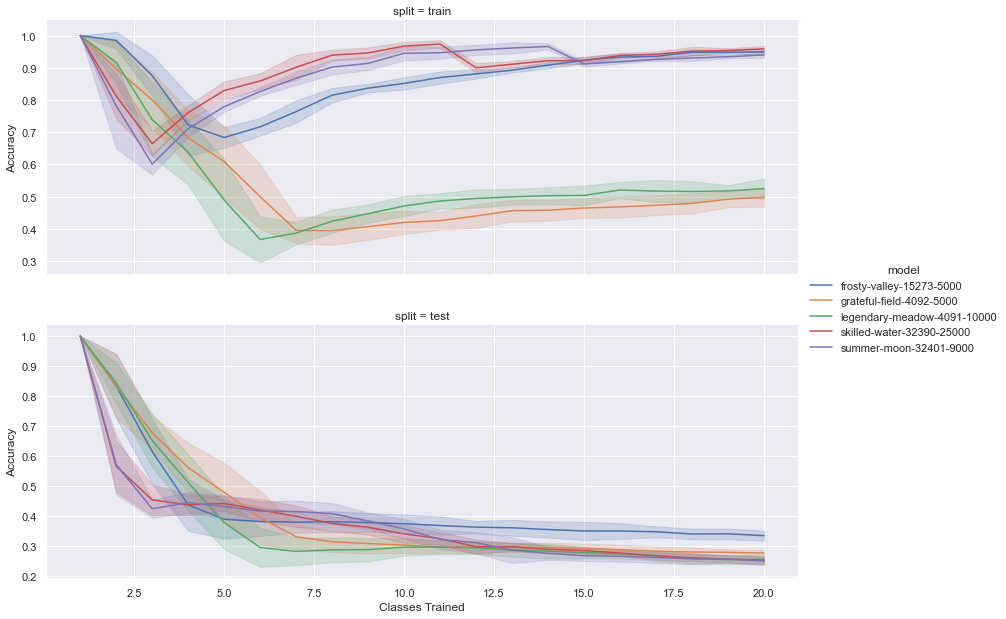

In [343]:
# Re-do the plot with just the top models.
_ = plot_traj_per_lr(top_model_df)

### Best Models Per Category

In [375]:
best_olft_models = get_top_model_per_group(olft_best_lrs, olft_perf_per_model)
best_olft_models

mean       std
train_method        lobotomize model                                          
iid                 False      rose-plant-14901-2000        0.230350  0.030252
meta                False      skilled-water-32390-25000    0.253050  0.012716
                    True       legendary-meadow-4091-10000  0.257175  0.014982
sequential_episodic False      summer-moon-32401-9000       0.251025  0.013970
                    True       frosty-valley-15273-5000     0.335425  0.017080

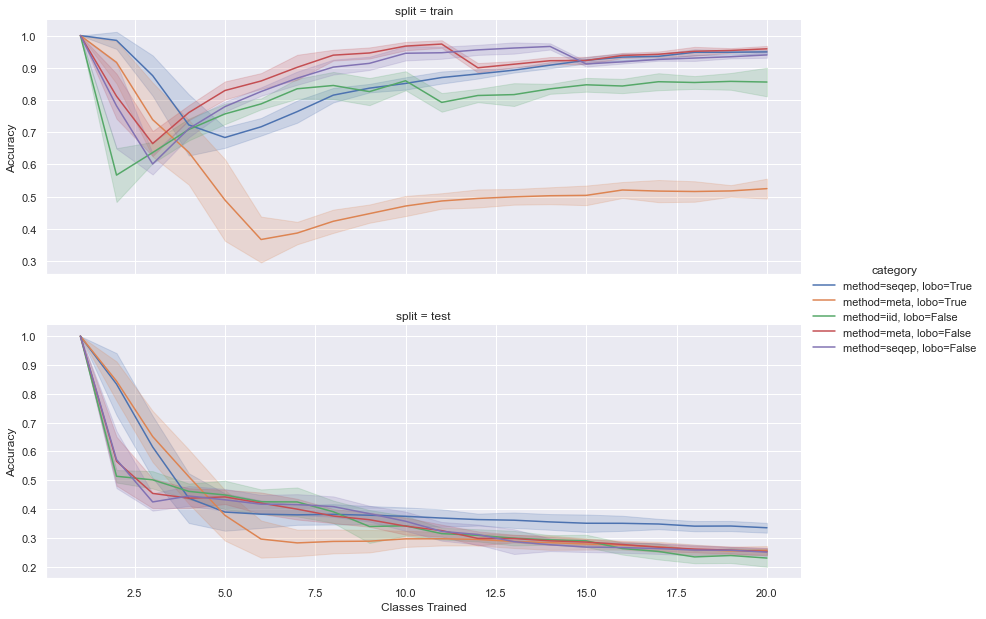

In [379]:
# Now plot them.
best_olft_df = filter_to_match_models(olft_best_lrs, best_olft_models).copy()
add_category_column(best_olft_df)
_ = plot_traj_per_lr(best_olft_df, hue="category")

# i.i.d. Fine-Tuning Evaluation

## Unfrozen

### Best Models Per Category

In [267]:
iid_df = all_frames["iid-unfrozen"].drop(["train_top5_acc", "test_top5_acc"], axis="columns")
iid_overall_accuracy = combine_train_test_columns(iid_df)

In [274]:
# Filter the data to the desired number of training examples.
num_train_examples = 500
rows = iid_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
desired_rows = iid_overall_accuracy.loc[rows]
iid_best_lrs = select_best_lr_per_group(desired_rows)

In [321]:
# Print final accuracy per model, when fine-tuned on this number of examples.
iid_perf_per_model = get_final_perf_per_model(iid_best_lrs, num_train_examples, print_result=True)

Final accuracy on 20 classes:
        absurd-wave-14899-2000 | 33.3% (std: 1.3%)
     atomic-pyramid-32397-9000 | 25.2% (std: 1.4%)
       copper-water-14900-2000 | 49.5% (std: 1.2%)
     curious-brook-15280-10000 | 53.8% (std: 1.8%)
       dandy-cloud-32392-25000 | 34.0% (std: 1.6%)
        denim-surf-32389-25000 | 48.3% (std: 1.3%)
         fast-voice-32404-5000 | 29.5% (std: 2.0%)
     fresh-elevator-32398-5000 | 21.2% (std: 1.8%)
  frosty-resonance-15286-10000 | 19.6% (std: 1.7%)
      frosty-valley-15273-5000 | 54.0% (std: 0.6%)
      grateful-field-4092-5000 | 51.2% (std: 1.6%)
      helpful-jazz-32396-25000 | 47.6% (std: 1.4%)
        iconic-snow-15277-5000 | 11.6% (std: 2.1%)
   legendary-meadow-4091-10000 | 52.7% (std: 1.2%)
     logical-disco-32391-25000 | 50.9% (std: 2.0%)
        olive-sponge-4090-5000 | 45.9% (std: 1.2%)
        pious-dream-32403-5000 | 37.1% (std: 1.4%)
        proud-wave-15282-10000 | 39.1% (std: 1.5%)
      rich-universe-32399-9000 | 45.5% (std: 2.2%)
 

In [323]:
best_iid_models = get_top_model_per_group(iid_best_lrs, iid_perf_per_model)
best_iid_models

mean       std
train_method        lobotomize model                                       
iid                 False      copper-water-14900-2000    0.49480  0.012109
meta                False      logical-disco-32391-25000  0.50945  0.019677
                    True       curious-brook-15280-10000  0.53815  0.018212
sequential_episodic False      summer-moon-32401-9000     0.48605  0.012812
                    True       frosty-valley-15273-5000   0.54045  0.006094

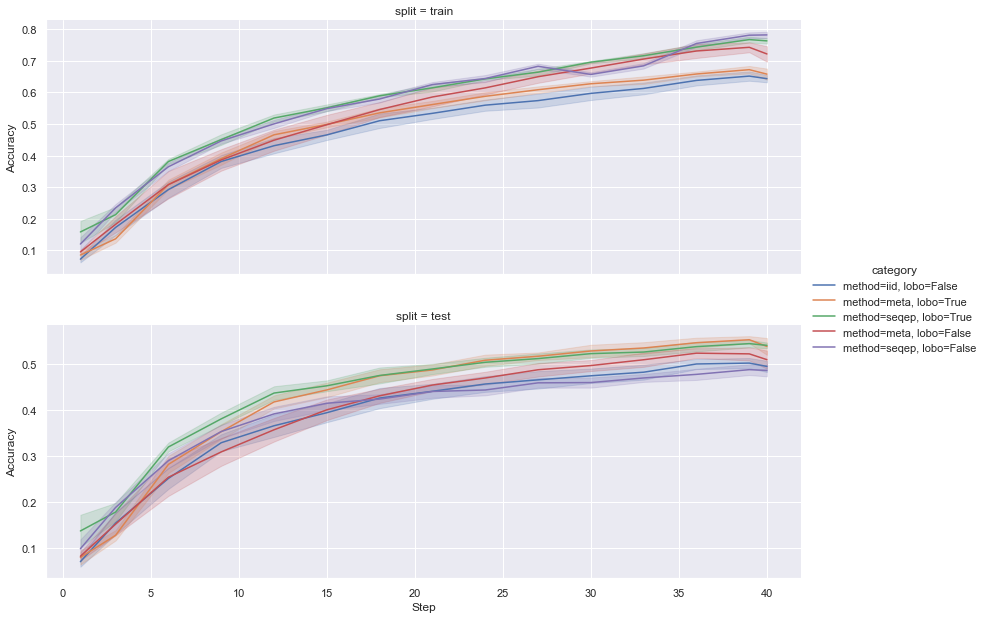

In [372]:
# Now plot them. Copy to avoid a SettingWithCopy warning.
best_iid_df = filter_to_match_models(iid_best_lrs, best_iid_models).copy()
add_category_column(best_iid_df)
_ = plot_traj_per_lr(best_iid_df, hue="category")

# Sensitivity to Learning Rate (Deprecated)

This section has not yet been updated to conform to the new dataframe format.

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


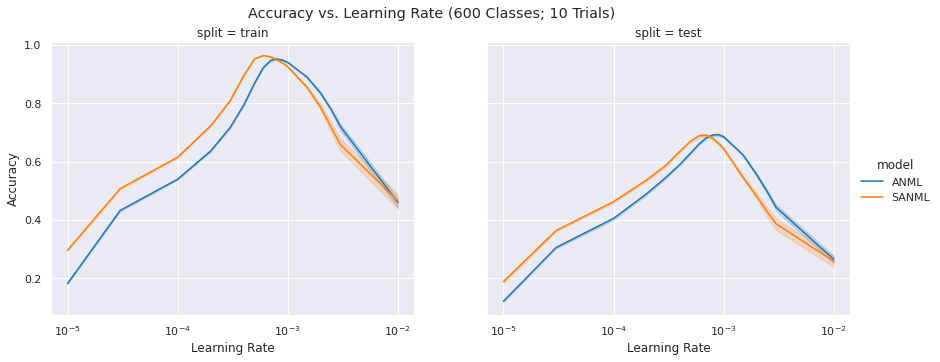

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(olft_overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Scratch Space

In [167]:
%%time
# Average over all classes to get overall performance numbers, by grouping by columns other than class.
# groupby_labels = get_index_columns(classes_seen_perf, exclude=["class_id"])
# print(groupby_labels)
groupby_labels = ['model', 'dataset', 'train_examples', 'test_examples', 'eval_method', 'reinit_method', 'reinit_params',
                  'opt_params', 'classes', 'lr', 'trial', 'epoch', 'classes_trained', 'train_method',
                  'lobotomize']#, 'model_name']

def myfun(grp):
    print(f"got a group:\n{grp}")
    return grp.mean()

print(f"grouping by: {groupby_labels}")
df = classes_seen_perf.head(1000).copy()
newdex = df.index.to_frame(index=False)
sz = len(newdex["lobotomize"])
halfsz = int(sz / 2)
newdex["lobotomize"][:halfsz] = 1.3
newdex = pd.MultiIndex.from_frame(newdex, names=newdex.columns)
df.set_index(newdex, inplace=True)
groups = df.groupby(groupby_labels, dropna=False)
# groups.apply(myfun)
# print(len(groups))
# for n, g in groups:
#     print(f"group {n}:\n{g}")
groups.mean()

grouping by: ['model', 'dataset', 'train_examples', 'test_examples', 'eval_method', 'reinit_method', 'reinit_params', 'opt_params', 'classes', 'lr', 'trial', 'epoch', 'classes_trained', 'train_method', 'lobotomize']
CPU times: user 36.8 ms, sys: 6.12 ms, total: 43 ms
Wall time: 68.8 ms


<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train_acc  \
model                  dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr   trial epoch classes_trained train_method lobotomize              
absurd-wave-14899-2000 miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.01 0     0     1               iid          1.3          1.000000   
                                                                                                                                           1     2               iid          1.3          0.500000   
                                                                                                                                           2     3               iid          1.3          0.333333   
                                                                                                                                           3     4               iid          1.3          0.250000   
                                                                                                                                           4     5               iid          1.3          0.200000   
                                                                                                                                           5     6               iid          1.3          0.166667   
                                                                                                                                           6     7               iid          1.3          0.142857   
                                                                                                                                           7     8               iid          1.3          0.125000   
                                                                                                                                           8     9               iid          1.3          0.111111   
                                                                                                                                           9     10              iid          1.3          0.100000   
                                                                                                                                           10    11              iid          1.3          0.090909   
                                                                                                                                           11    12              iid          1.3          0.083333   
                                                                                                                                           12    13              iid          1.3          0.076923   
                                                                                                                                           13    14              iid          1.3          0.071429   
                                                                                                                                           14    15              iid          1.3          0.066667   
                                                                                                                                           15    16              iid          1.3          0.062500   
                                                                                                                                           16    17              iid          1.3          0.058824   
                                                                                                                                           17    18              iid          1.3          0.055556   
                                                                                                                                           18    19              iid          1.3          0.052632   
       